In [1]:
import json
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
plt.rcParams['font.family'] = ['SimHei', 'Times New Roman']

In [2]:
class const:
    # 数据文件名相关
    label_ch_list = ['房颤', '动脉粥样硬化', '心梗', '脑梗']
    label_en_list = ['AF', 'AS', 'MI', 'CI']
    confidence_score_f = 'std×pp'
    # 置信得分数据、预测评估源数据
    confidence_score_dict = r'..\..\PycharmProject-202412-集成学习\绘图数据【保留】\%s%s-confidence-score-dict-func=%s.json'
    do_write_predict_information_json_path = r'..\..\PycharmProject-202412-集成学习\绘图数据【保留】\%s%s-predict-information-dict-func=%s.json'
    # Logistic回归相关
    degree = 3
    lam = 100
    density = 200
    threshhold = 2 * 10 ** -2
    # 函数拟合参数
    # popt = {'AF': [-0.12624826, 0.20331957, 0.43457583], 'AS': [-0.53775715, 1.87577197, -0.67785164],
    #         'MI': [-0.51259901, 1.71942337, -0.54627487], 'CI': [-1.35737578, 3.64757585, -1.64243702]}
    popt = {'AF': [], 'AS': [], 'MI': [], 'CI': []}
    legend_loc = {'AF': 'lower right', 'AS': 'lower left', 'MI': 'lower left', 'CI': 'lower left'}

#### 准备Logistic回归所需的样本空间、标记空间、处理样本空间

#### feature_mapping
将二维特征映射到高维空间中，该高维空间的维数是："(const.degree+1)(const.degree+2)/2"<br>
笔记："f%d%d"：求和为0(%d+%d=0)：f00；求和为1：f10,f01；求和为2：f20,f11,f02；求和为3：f30,f21,f12,f03；依次类推<br>
笔记：np.power(x1, i - p) * np.power(x2, p)：x1^(i-p)*x2^p。特例：i=p=0时，x1^(i-p)*x2^p恒等于1<br>
笔记："f00":[]：该列表的长度由x1的长度决定，x1有200个元素，那么"f00":[]就有200个元素

In [3]:
def prepare_data(label_en, label_ch):
    now_json_path_file_name = const.confidence_score_dict % (label_en, label_ch, const.confidence_score_f)
    confidence_score_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))
    pred_pro_weighted_sum_true = confidence_score_dict["true"]["pred_pro_weighted_sum"]  # 正类数据：风险概率
    pred_pro_confidence_true = confidence_score_dict["true"]["pred_pro_confidence"]  # 正类数据：置信得分
    pred_pro_weighted_sum_false = confidence_score_dict["false"]["pred_pro_weighted_sum"]  # 负类数据：风险概率
    pred_pro_confidence_false = confidence_score_dict["false"]["pred_pro_confidence"]  # 负类数据：置信得分
    logistic_inputs_x = np.array([pred_pro_weighted_sum_true + pred_pro_weighted_sum_false, pred_pro_confidence_true + pred_pro_confidence_false])
    logistic_inputs_y = np.concatenate((np.ones(len(pred_pro_weighted_sum_true)), np.zeros(len(pred_pro_weighted_sum_false)))).astype(int)
    return logistic_inputs_x.T, logistic_inputs_y  # 返回模型输入：样本空间、标记空间
def feature_mapping(x1, x2, as_ndarray=False):
    data = {}
    for i in np.arange(const.degree + 1):
        for p in np.arange(i + 1):
            data["f%d%d" % (i - p, p)] = np.power(x1, i - p) * np.power(x2, p)
    return np.array(pd.DataFrame(data)) if as_ndarray else pd.DataFrame(data)

#### Logistic回归：拟合参数

#### sigmoid
对于Logistic回归分布函数"F(x)=1/(1+e^(-(x-u)/r))"<br>
对于此x，假设不添加w以改变它的相对位置<br>
则它在"y=1/(1+e^(-x))"上的分类只有一种结果：要么只能落在x=0左边，要么只能落在x=0右边<br>
wx的形式使得x有机会落在"y=1/(1+e^(-wx))"的左边或右边<br>
调整w的目的是尽可能使大部分x落在正确的一边<br>
https://blog.csdn.net/xq151750111/article/details/121871627 Logistic 回归的决策边界<br>
https://blog.csdn.net/xq151750111/article/details/121341143 线性分类（三）-- 逻辑回归 LR<br>
https://blog.csdn.net/hgnuxc_1993/article/details/114680399 逻辑斯谛回归（Logistic回归）最详解<br>
https://zhuanlan.zhihu.com/p/75364861 吴恩达机器学习笔记（三）——正则化（Regularization）<br>
D:\工作文件\9.1-无法分类-pdf\书籍类-z-章节截取\机器学习-周志华-3-线性模型_69_88.pdf<br>
https://blog.csdn.net/qq_34720818/article/details/103684070 机器学习（七）逻辑回归之代价函数<br>
https://blog.csdn.net/weixin_42504788/article/details/135635063 机器学习_假设(预测)函数——h(x)、损失(误差)函数——L(w, b)<br>
#### calc_regularized_loss
损失函数，"Logistic回归"正则化代价函数, learning_rate=0.1<br>
笔记：theta：初始猜测的数组theta=np.zeros(data.shape[1])；x：data=DataFrama{"f00":[],"f01":[],"f10":[],...}<br>
笔记：对于"损失函数"的理解：opt.minimize(fun=regularized_cost)的目的是期望最小化"total_cost"数值，那么"total_cost=0.6931"与"目标值=0"之间的差异就是损失<br>
笔记：对于分类问题中"正则化代价"的理解：做正则前，所有物质都归为一类，做正则后，所有物质明确区分为两类；<br>
笔记：此处"正则化代价"就是分类器通过二维数值将两种物质区分时，产生的几乎不可避免的错误。因此，分类问题"损失函数"返回值，就是分类问题的"正则化代价"<br>
笔记："total_cost"返回当前参数情况下的损失之和<br>
笔记：对于"parameters_loss"的理解：<br>
笔记：由于高次项导致的过拟合的发生，所以如果能够让那些高次项的系数接近于0，就能够很好的拟合数据集。<br>
笔记：所以，将参数也纳入损失函数中，目的是尽可能最小化参数，并最终导致选择较小一些的theta。<br>
笔记：按照惯例，不会将纳入损失函数的参数损失中，即不会计算theta[0]带来的损失。<br>
#### calc_regularized_gradient
梯度下降，正则化梯度<br>
笔记：theta：初始猜测的数组theta=np.zeros(data.shape[1])；x：data=DataFrama{"f00":[],"f01":[],"f10":[],...}<br>
笔记：const.degree=6时的某次实验，regularized_gradient循环了137次；const.degree=3时的某次实验，regularized_gradient循环了71次<br>
笔记：Series{'f00':'-0.0650','f10':'-0.0378','f01':'0.0158','f20':'0.3200','f11':'-0.0381','f02':'0.2807','f30':'-0.1340','f21':'0.0507','f12':'-0.0603',<br>
'f03':'0.0741','f40':'1.7541','f31':'-0.2747','f22':'0.6657','f13':'-0.3271','f04':'1.2823','f50':'-0.8449','f41':'0.5226','f32':'-0.7344','f23':'0.8808',<br>
'f14':'-0.9148','f05':'0.7619','f60':'12.0887','f51':'-2.9171','f42':'3.8703','f33':'-2.7801','f24':'4.1507','f15':'-3.7438','f06':'7.7431'}<br>
笔记：不计算theta[0]带来的损失，所以theta[0]的梯度为0，不需要优化theta[0]的数值<br>
#### feature_mapped_logistic_regression
仅用于绘图目的..不是一个很好的广义 Logistic 回归<br>
笔记：scipy.optimize.minimize是一个使优化目标最小化的方法，此处期望最小化的是"regularized_cost"函数返回的"total_cost"<br>
笔记：而"regularized_gradient"函数负责不断更新"theta"系数列表，目的是达到最小化"total_cost"的目标<br>
笔记：fun：待求解的目标函数（即损失函数）；x0=theta：初始猜测的数组；args：目标函数带参数时需要指定；jac：梯度函数<br>
笔记：因此，optimize.minimize的优化目标就是"损失函数regularized_cost"的返回值，使其尽可能小<br>
笔记：res.x就是regularized_gradient()最后一次返回的total_gradient<br>
#### do_work
用特征映射Logistic回归思想，寻找决策边界上的离散点，再拟合决策边界函数<br>
笔记：const.degree: 映射"特征多项式"的最高次幂；const.lam: 正则化项的Lambda常数<br>
笔记：feature_mapped_logistic_regression()函数目的是拟合参数，（或者理解为拟合系数），final_theta列表即为训练所得的"特征多项式系数"<br>
笔记：find_decision_boundary()函数目的寻找决策边界上的离散点，其中density表示网格点密度，threshhold表示预测值允许误差的上界

In [4]:
def sigmoid(z):  # sigmoid函数
    return 1 / (1 + np.exp(-z))
def calc_regularized_loss(theta, x, y):  # 正则化损失函数
    classify_predict = sigmoid(np.dot(x, theta))  # 分类预测结果
    training_loss = np.mean(-y * np.log(classify_predict) - (1 - y) * np.log(1 - classify_predict))  # 训练损失
    parameters_loss = (1 / (2 * len(x))) * np.power(theta[1:], 2).sum()  # 参数损失：将参数也纳入损失函数中，目的是尽可能最小化参数，以尽可能避免过拟合
    return training_loss + parameters_loss  # 返回正则化损失，正则化损失=训练损失+参数损失
def calc_regularized_gradient(theta, x, y):  # 正则化梯度函数
    classify_predict = sigmoid(np.dot(x, theta))  # 分类预测结果
    training_gradient = (1 / len(x)) * np.dot(x.T, classify_predict - y)  # 训练梯度
    parameters_gradient_higher_term = (const.lam / len(x)) * theta[1:]  # 参数梯度（高次项参数）
    parameters_gradient = np.concatenate([np.array([0]), parameters_gradient_higher_term])  # 参数梯度（所有参数）
    return training_gradient + parameters_gradient  # 返回正则化梯度，正则化梯度=训练梯度+参数梯度
def feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y):
    inputs_x = feature_mapping(logistic_inputs_x[:, 0], logistic_inputs_x[:, 1], as_ndarray=True)
    theta = np.zeros(inputs_x.shape[1])  # 初始猜测的数组
    res = opt.minimize(fun=calc_regularized_loss, x0=theta, args=(inputs_x, logistic_inputs_y), method='TNC', jac=calc_regularized_gradient)  # 拟合
    final_theta = res.x  # 获取拟合参数
    return final_theta

#### 寻找决策边界上的离散点、拟合决策边界、保存拟合阈值曲线参数、绘制决策边界

In [15]:
def find_decision_boundary(theta):  # 寻找决策边界上的离散点
    x_interval_value = np.linspace(0, 1, const.density)  # 生成等距间隔值
    y_interval_value = np.linspace(0, 1, const.density)  # 生成等距间隔值
    coordinate_value = [(x, y) for x in x_interval_value for y in y_interval_value]  # 生成网格化坐标点(x, y)，坐标点数量为间隔值数量的平方
    x_coordinate, y_coordinate = zip(*coordinate_value)  # 遍历出每个坐标点的横坐标值、纵坐标值
    map_high_dimensional = feature_mapping(x_coordinate, y_coordinate)  # 对于mapped_coordinate，行数：间隔值数量的平方；列数：(const.degree+1)(const.degree+2)/2
    distance = np.dot(np.array(map_high_dimensional), theta)  # 矩阵叉乘。theta行数：高维空间的维数；列数：1。theta行数：高维空间的维数；列数：1
    decision = map_high_dimensional[np.abs(distance) < const.threshhold]
    # 笔记："*coordinate_value"表示将"坐标值"列表转化为"坐标值"元组，则返回的"横坐标值"、"纵坐标值"也都是元组数据格式
    # 笔记：将二维特征映射到高维空间中，该高维空间的维数是："(const.degree+1)(const.degree+2)/2"
    # 笔记：将训练所得的各个系数theta[i]，分别与每个高维坐标对应的坐标值相乘，所得结果为先前二维特征的"预测值"。该预测值可以理解为二维坐标点与决策边界的某种距离
    # 笔记：找到distance中绝对值小于阈值threshhold=0.002的元素，并得知这些元素在distance中的索引。再在map_high_dimensional上引用该索引，得到决策边界上的离散点
    # 笔记：此处阈值threshhold=0.002也可以理解为误差，即误差小于0.002，对应的坐标点(x,y)才能被看作是决策边界上的点，才能被选择
    # 笔记：decision就是决策边界上的离散点了。下一步，返回这些离散点在直角坐标系中的横坐标值（decision.f10=x1^1*x2^0）、纵坐标值（decision.f01=x1^0*x2^1）
    return decision.f10, decision.f01
def fit_func(x, a, b, c):  # 变量一定要放在第一个位置
    return a * x ** 2 + b * x + c
def curve_fit_boundary(label_en, boundary_x_coordinate, boundary_y_coordinate):
    const.popt[label_en], pcov = opt.curve_fit(fit_func, boundary_x_coordinate, boundary_y_coordinate)  # p0 = 1是因为只有a一参数
    boundary_y_coordinate_fit = fit_func(boundary_x_coordinate, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2])
    return boundary_y_coordinate_fit  # popt[0],popt[1],popt[2]分别代表参数a b c
def draw_boundary(label_en, logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate, boundary_y_coordinate_fit):  # 用离散点模拟绘制决策边界
    fig_3 = plt.figure(figsize=(16, 8))
    ax1=fig_3.add_subplot(111)
    plt.scatter(logistic_inputs_x[:, 0][logistic_inputs_y == 0], logistic_inputs_x[:, 1][logistic_inputs_y == 0], label='错误分类', c='r', s=1)
    plt.scatter(logistic_inputs_x[:, 0][logistic_inputs_y == 1], logistic_inputs_x[:, 1][logistic_inputs_y == 1], label='正确分类', c='k', s=1)  # 按分类绘制数据样本点
    # plt.scatter(boundary_x_coordinate, boundary_y_coordinate, label='拟合决策边界', c='g', s=5)
    plt.plot(boundary_x_coordinate, boundary_y_coordinate_fit, label='拟合阈值曲线', c='b', linewidth=3)
    plt.legend(loc=const.legend_loc[label_en], shadow=True, fancybox=True)
    plt.rcParams.update({'font.size': 32})
    plt.xlabel('风险概率')
    plt.ylabel('置信得分')
    # plt.title('')
    ax1.set_xlim([-0.02, 1.02])
    # ax1.set_ylim([0.75, 1.02])
    ax1.spines['bottom'].set_linewidth(3)#设置底部坐标轴的粗细
    ax1.spines['left'].set_linewidth(3)#设置左边坐标轴的粗细
    ax1.spines['right'].set_linewidth(3)#设置右边坐标轴的粗细
    ax1.spines['top'].set_linewidth(3)#设置上部坐标轴的粗细
    plt.show()

#### 计数标签和计算评估值

In [6]:
def prepare_predict_information(label_en, label_ch):
    now_json_path_file_name = const.do_write_predict_information_json_path % (label_en, label_ch, const.confidence_score_f)
    predict_information_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))
    pred_pro_weighted_sum = np.array(predict_information_dict["pred_pro_weighted_sum"])
    pred_pro_confidence_score = np.array(predict_information_dict["pred_pro_confidence_score"])
    test_data_label_arr = np.array(predict_information_dict["test_data_label_arr"]).astype(int)  # 问题：JSON不能保存np.int，所以用float代替；此处转化回来
    pred_label_arr = np.array(predict_information_dict["pred_label_arr"]).astype(int)
    return pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr
def prepare_predict_information_dict(label_en, pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr):
    judge_y = pred_pro_confidence_score - fit_func(pred_pro_weighted_sum, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2])
    above_fit_func_index = np.where(judge_y >= 0)[0]  # 当popt的保留小数位数较短时，up_data_index/down_data_index内元素的个数将产生个位数的偏差
    below_fit_func_index = np.where(judge_y < 0)[0]
    above_fit_func_predict_information = {
        "pred_pro_weighted_sum": pred_pro_weighted_sum[above_fit_func_index],
        "test_data_label_arr":   test_data_label_arr[above_fit_func_index],
        "pred_label_arr":        pred_label_arr[above_fit_func_index]
    }
    below_fit_func_predict_information = {
        "pred_pro_weighted_sum": pred_pro_weighted_sum[below_fit_func_index],
        "test_data_label_arr":   test_data_label_arr[below_fit_func_index],
        "pred_label_arr":        pred_label_arr[below_fit_func_index]
    }
    return above_fit_func_predict_information, below_fit_func_predict_information
def calc_accuracy(tp, tn, amount_sum):
    return (tp + tn) / amount_sum
def calc_ppv(tp, fp):
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)
def calc_tpr(tp, fn):
    return tp / (tp + fn)
def calc_f1(tp, fn, fp):
    return 2 * tp / (2 * tp + fn + fp)  # 2*ppv*tpr/(ppv+tpr)
def count_label_arr_and_calc_assessed_values(predict_information_dict):
    predict_positive_label_index = np.where(predict_information_dict["pred_label_arr"] == 1)[0]
    predict_negative_label_index = np.where(predict_information_dict["pred_label_arr"] == 0)[0]
    test_data_positive_label_index = np.where(predict_information_dict["test_data_label_arr"] == 1)[0]
    test_data_negative_label_index = np.where(predict_information_dict["test_data_label_arr"] == 0)[0]
    tp_index = list(set(predict_positive_label_index) & set(test_data_positive_label_index))  # 取交集
    fn_index = list(set(predict_negative_label_index) & set(test_data_positive_label_index))
    fp_index = list(set(predict_positive_label_index) & set(test_data_negative_label_index))
    tn_index = list(set(predict_negative_label_index) & set(test_data_negative_label_index))
    tp_num = len(tp_index)  # 正类标记，被预测成正类的个数
    fn_num = len(fn_index)  # 正类标记，被预测成负类的个数
    fp_num = len(fp_index)  # 负类标记，被预测成正类的个数
    tn_num = len(tn_index)  # 负类标记，被预测成负类的个数
    amount_sum = tp_num + fn_num + fp_num + tn_num  # 总数
    false_positive_rate, true_positive_rate, thresholds_list = \
        roc_curve(predict_information_dict["test_data_label_arr"], predict_information_dict["pred_pro_weighted_sum"], pos_label=1)
    calc_assessed_values = {
        "acc":    calc_accuracy(tp_num, tn_num, amount_sum),
        "ppv":    calc_ppv(tp_num, fp_num),
        "tpr":    calc_tpr(tp_num, fn_num),
        "f1":     calc_f1(tp_num, fn_num, fp_num),
        "au_roc": auc(false_positive_rate, true_positive_rate),
        "tp_num": tp_num, "fn_num": fn_num, "fp_num": fp_num, "tn_num": tn_num
    }
    return calc_assessed_values
def print_assessed_values(label_en, label_ch):
    float_assessed_values_name_list = ["ACC", "PPV", "TPR", "F1", "AUC"]
    float_assessed_values_name_lowercase_list = ["acc", "ppv", "tpr", "f1", "au_roc"]
    int_assessed_values_name_list = ["TP", "FN", "FP", "TN"]
    int_assessed_values_name_lowercase_list = ["tp_num", "fn_num", "fp_num", "tn_num"]
    # 导入风险概率、置信得分、标记空间、预测结果
    pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr = prepare_predict_information(label_en, label_ch)
    # 区分高置信区间、低置信区间的风险概率、置信得分、标记空间、预测结果
    above_fit_func_predict_information, below_fit_func_predict_information =\
        prepare_predict_information_dict(label_en, pred_pro_weighted_sum, pred_pro_confidence_score, test_data_label_arr, pred_label_arr)
    # 评估高置信区间的预测效果
    calc_assessed_values_above_fit_func = count_label_arr_and_calc_assessed_values(above_fit_func_predict_information)
    # 评估低置信区间的预测效果
    calc_assessed_values_below_fit_func = count_label_arr_and_calc_assessed_values(below_fit_func_predict_information)
    # 输出拟合阈值曲线
    print('%s拟合阈值曲线：y = %.3f x^2 + %.3f x + %.3f\n' % (label_ch, const.popt[label_en][0], const.popt[label_en][1], const.popt[label_en][2]))
    # 输出评估
    print("%s\n\t高置信区间\t低置信区间" % label_ch)
    for name, name_lowercase in zip(float_assessed_values_name_list, float_assessed_values_name_lowercase_list):
        print("%s\t%.3f\t\t%.3f" % (name, calc_assessed_values_above_fit_func[name_lowercase], calc_assessed_values_below_fit_func[name_lowercase]))
    for name, name_lowercase in zip(int_assessed_values_name_list, int_assessed_values_name_lowercase_list):
        print("%s\t%d\t\t%d" % (name, calc_assessed_values_above_fit_func[name_lowercase], calc_assessed_values_below_fit_func[name_lowercase]))

In [7]:
def do_work(label_en, label_ch):
    # 准备Logistic回归所需的样本空间、标记空间
    logistic_inputs_x, logistic_inputs_y = prepare_data(label_en, label_ch)
    # 拟合Logistic回归参数
    final_theta = feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y)
    # 寻找决策边界上的离散点
    boundary_x_coordinate, boundary_y_coordinate = find_decision_boundary(final_theta)
    # 拟合决策边界、保存拟合阈值曲线参数
    boundary_y_coordinate_fit = curve_fit_boundary(label_en, boundary_x_coordinate, boundary_y_coordinate)
    # 绘制风险概率-置信得分图、绘制决策边界坐标点、绘制决策边界拟合阈值曲线
    draw_boundary(label_en, logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate, boundary_y_coordinate_fit)
    # 输出拟合阈值曲线、计数标签和计算评估值
    print_assessed_values(label_en, label_ch)

In [8]:
# label_en, label_ch = const.label_en_list[0],const.label_ch_list[0]
# logistic_inputs_x, logistic_inputs_y = prepare_data(label_en, label_ch)
# final_theta = feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y)
# boundary_x_coordinate, boundary_y_coordinate = find_decision_boundary(final_theta)
# boundary_y_coordinate_fit = curve_fit_boundary(label_en, boundary_x_coordinate, boundary_y_coordinate)
# draw_boundary(label_en, logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate, boundary_y_coordinate_fit)

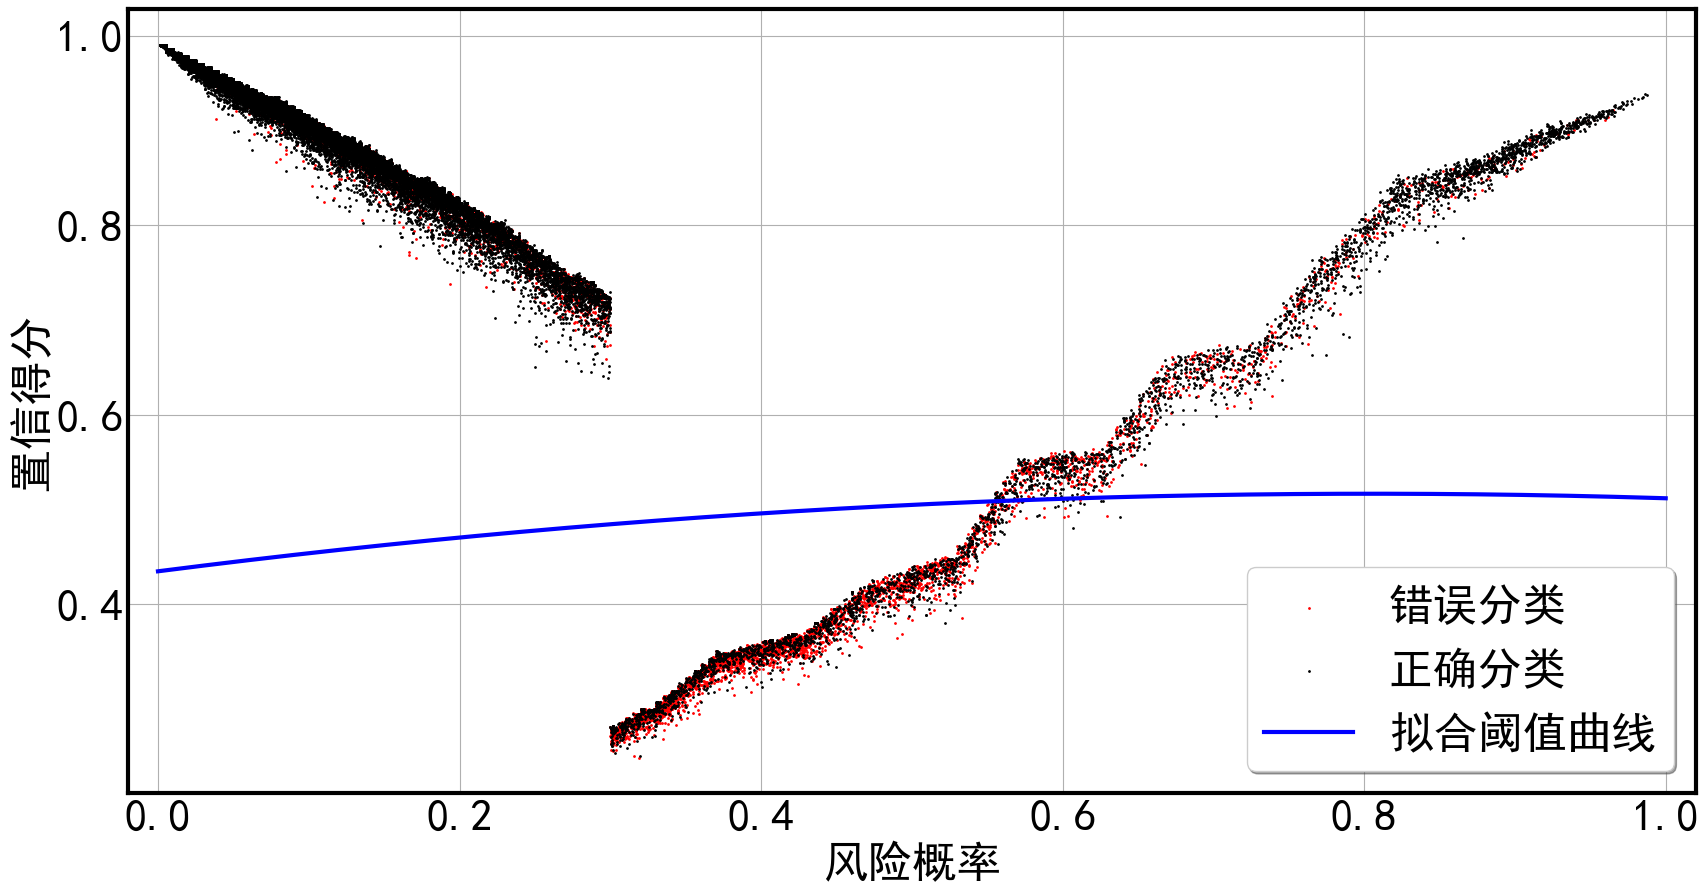

房颤拟合阈值曲线：y = -0.126 x^2 + 0.203 x + 0.435

房颤
	高置信区间	低置信区间
ACC	0.924		0.365
PPV	0.748		0.365
TPR	0.471		1.000
F1	0.579		0.535
AUC	0.891		0.575
TP	2148		1814
FN	2408		0
FP	722		3153
TN	36115		0


In [17]:
do_work(const.label_en_list[0],const.label_ch_list[0])

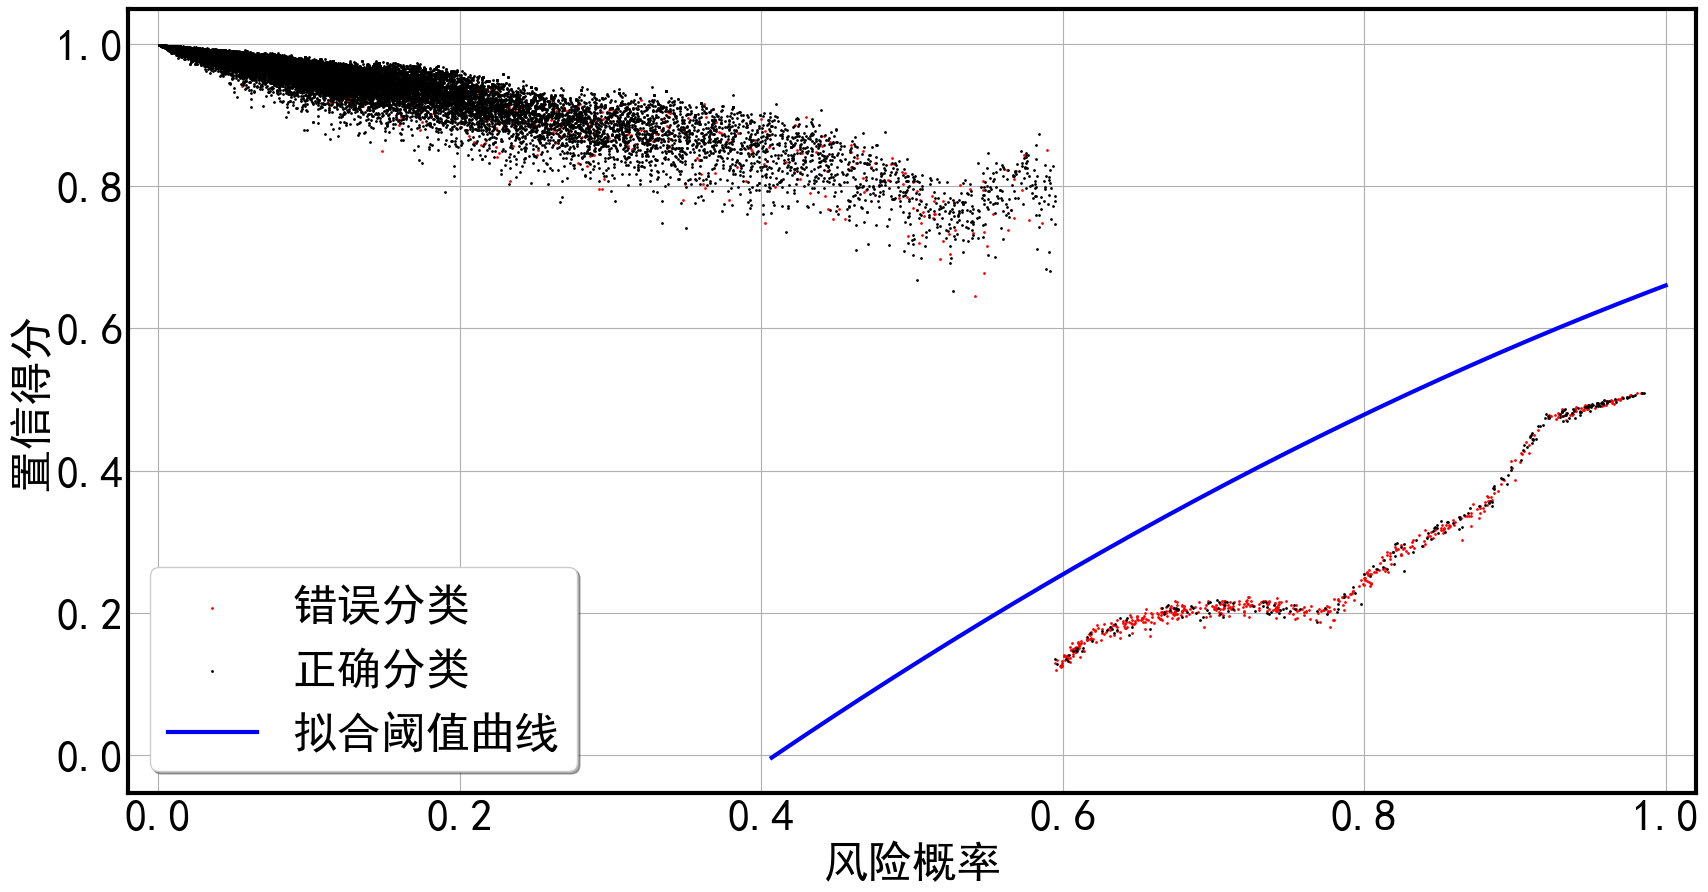

动脉粥样硬化拟合阈值曲线：y = -0.538 x^2 + 1.876 x -0.678

动脉粥样硬化
	高置信区间	低置信区间
ACC	0.988		0.298
PPV	0.000		0.298
TPR	0.000		1.000
F1	0.000		0.460
AUC	0.831		0.649
TP	0		225
FN	555		0
FP	0		529
TN	45051		0


In [18]:
do_work(const.label_en_list[1],const.label_ch_list[1])

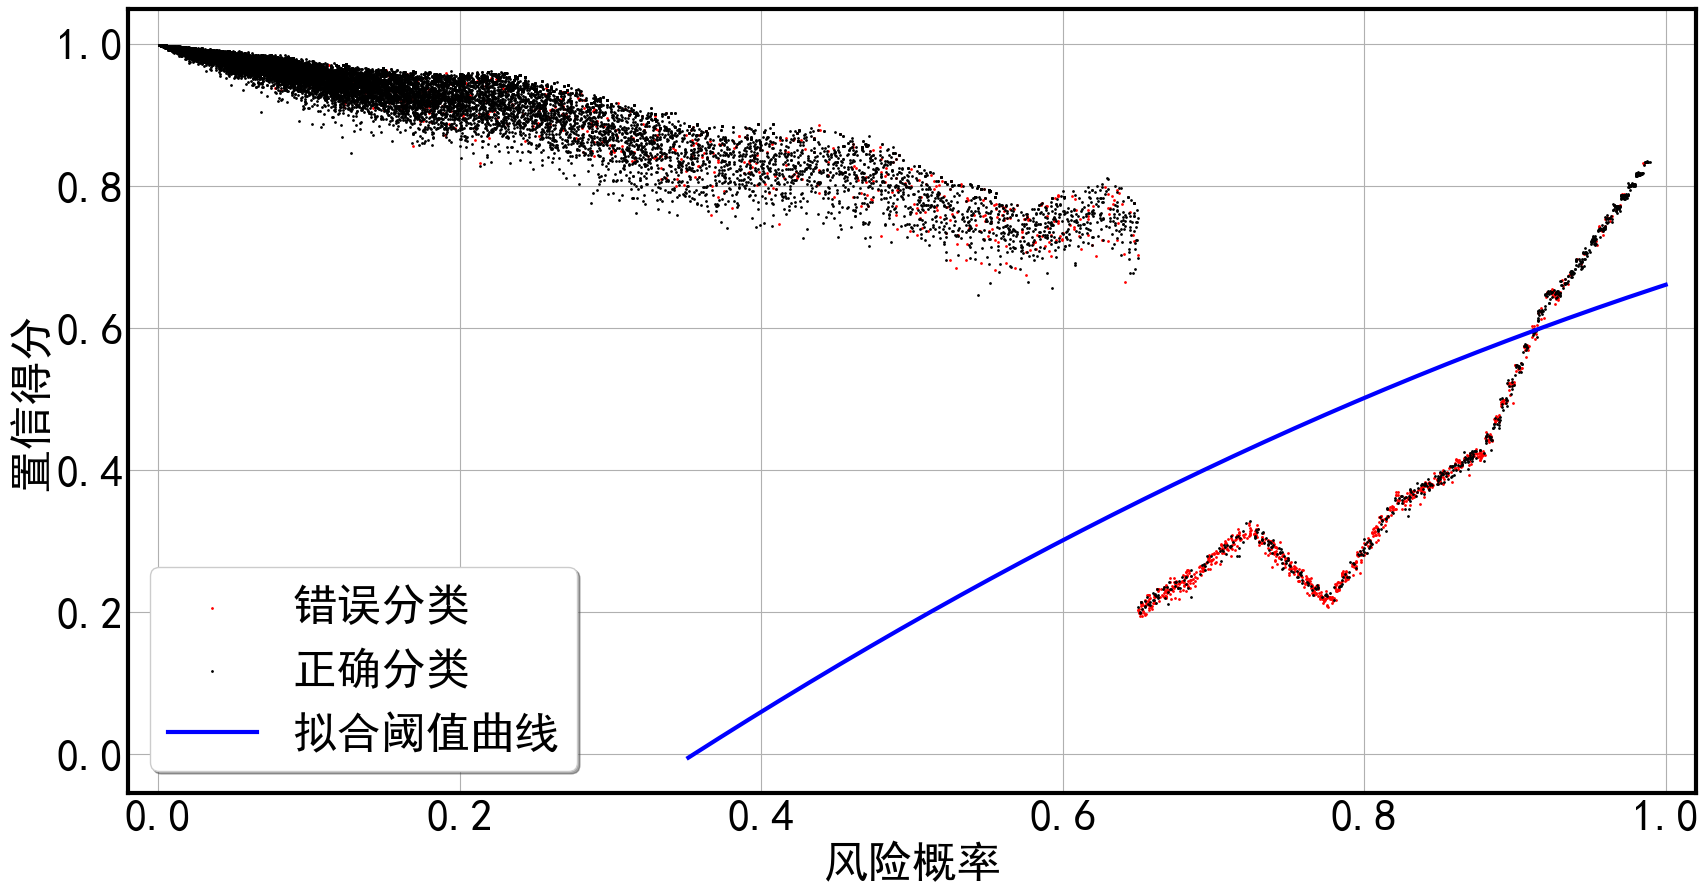

心梗拟合阈值曲线：y = -0.513 x^2 + 1.719 x -0.546

心梗
	高置信区间	低置信区间
ACC	0.981		0.337
PPV	0.790		0.337
TPR	0.273		1.000
F1	0.406		0.504
AUC	0.909		0.592
TP	301		387
FN	800		0
FP	80		762
TN	44030		0


In [19]:
do_work(const.label_en_list[2],const.label_ch_list[2])

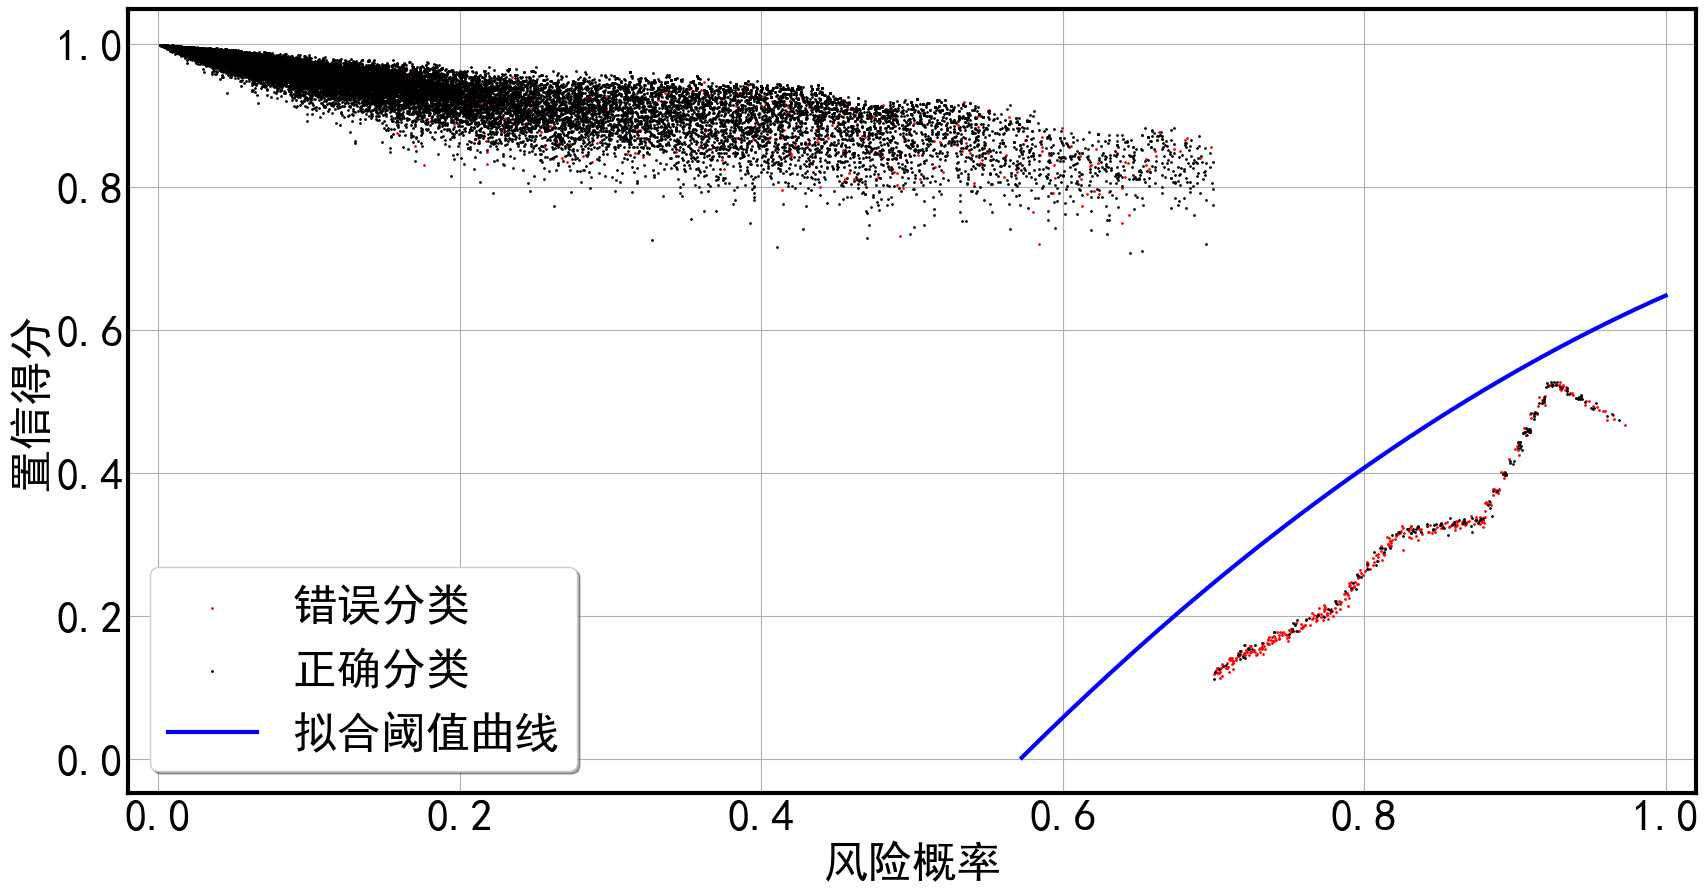

脑梗拟合阈值曲线：y = -1.357 x^2 + 3.648 x -1.642

脑梗
	高置信区间	低置信区间
ACC	0.986		0.317
PPV	0.000		0.317
TPR	0.000		1.000
F1	0.000		0.481
AUC	0.813		0.658
TP	0		178
FN	663		0
FP	0		384
TN	45135		0


In [20]:
do_work(const.label_en_list[3],const.label_ch_list[3])